In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

This script sets up a PyTorch-based machine learning pipeline using a custom dataset, integrating data loading, model building, and training utilities. It combines pandas for data handling, scikit-learn for splitting, and matplotlib for visualizations.

torch.manual_seed(42) sets the random seed for PyTorch's random number generator to ensure reproducibility in experiments. By using the same seed, results from random operations (e.g., initialization, data shuffling) can be consistently reproduced across runs.

In [77]:
torch.manual_seed(42)

This code checks if a CUDA-enabled GPU is available for PyTorch operations. If available, it sets the device to 'cuda', otherwise it defaults to 'cpu'. The print statement then outputs the current device being used for computation.

In [78]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'the device is :{device}')

the device is :cuda


The code snippet reads a CSV file (fashion-mnist_train.csv) into a Pandas DataFrame and then displays the first five rows using df.head(). This is typically used to inspect the structure of the dataset, showing columns and sample data.

In [79]:
df=pd.read_csv('/content/fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This code creates a 4x4 grid of images from the Fashion MNIST dataset, displaying the first 16 images with their corresponding labels as titles. It reshapes each image into 28x28 pixels and removes the axis for a cleaner visualization.


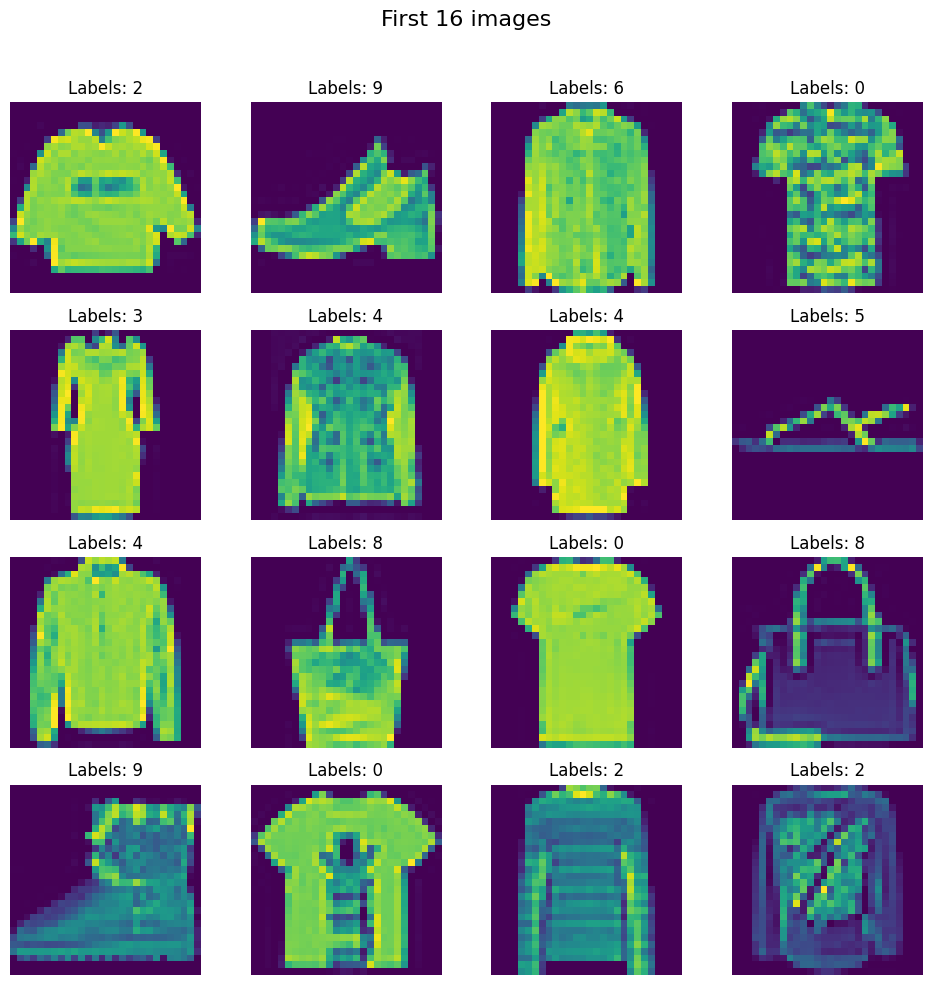

In [80]:
fig, axes=plt.subplots(4,4,figsize=(10,10))
fig.suptitle('First 16 images', fontsize=16)
for i, ax in enumerate(axes.flat):
  img=df.iloc[i, 1:].values.reshape(28,28)
  ax.imshow(img)
  ax.axis('off')
  ax.set_title(f'Labels: {df.iloc[i,0]}')
  plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

This code extracts the feature data (pixel values) and labels (target values) from the Fashion MNIST dataset. The features are stored in x, which includes all columns except the first (representing image pixels), and the labels are stored in y, which includes the first column (representing the class of each image).

In [81]:
x=df.iloc[:,1:].values
y=df.iloc[:, 0].values

In [82]:
x.shape

(60000, 784)

In [83]:
y.shape

(60000,)

This code splits the feature data (x) and labels (y) into training and testing sets, with 80% of the data for training and 20% for testing. It ensures reproducibility of the split using a fixed random_state value (42).

In [84]:
x_train, x_test, y_train, y_test=train_test_split(x,y, test_size=0.2, random_state=42)

In [85]:
x_train.shape

(48000, 784)

In [86]:
y_test.shape

(12000,)

In [87]:
y_train.shape

(48000,)

In [88]:
y_test.shape

(12000,)

This code normalizes the pixel values of the training and testing datasets by dividing them by 255.0. This scales the pixel values from the range [0, 255] to [0, 1], which helps improve the performance and convergence of machine learning models.

In [89]:
x_train=x_train/255.0
x_test=x_test/255.0

The CustomDataset class is a custom PyTorch dataset that converts feature data into a tensor suitable for CNN input and stores the corresponding labels. It defines methods to get the length of the dataset (__len__) and to retrieve a sample (image and label) by index (__getitem__). This class enables efficient loading and preprocessing of data for training in PyTorch.

In [90]:
class CustomDataset(Dataset):
  def __init__(self, features, labels):
    self.features=torch.tensor(features, dtype=torch.float32).reshape(-1,1,28,28)
    self.labels=torch.tensor(labels, dtype=torch.long)
  def __len__(self):
    return len(self.features)
  def __getitem__(self, index):
    return self.features[index], self.labels[index]

This line creates an instance of the CustomDataset class for the training data, where x_train contains the feature data (images) and y_train contains the corresponding labels. The train_dataset will now hold the preprocessed training data in the format suitable for PyTorch model training.

In [91]:
train_dataset=CustomDataset(x_train, y_train)

In [92]:
len(train_dataset)

48000

This line creates an instance of the CustomDataset class for the testing data, where x_test contains the feature data (images) and y_test contains the corresponding labels. The test_dataset will now hold the preprocessed testing data, ready for evaluation or inference in PyTorch.

In [93]:
test_dataset=CustomDataset(x_test, y_test)

This code creates data loaders for the training and testing datasets, with a batch size of 32. The training data is shuffled to ensure randomness during each epoch, while the testing data is not shuffled. Both loaders use pin_memory=True to optimize data transfer to the GPU, improving training and evaluation efficienc

In [94]:
train_dataloader=DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_dataloader=DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

The MyNN class defines a convolutional neural network (CNN) for Fashion MNIST classification. It consists of two convolutional layers with ReLU activation, batch normalization, and max-pooling for feature extraction, followed by fully connected layers with dropout for classification into 10 classes. The model is implemented using PyTorch's nn.Module.

In [108]:
import torch.nn as nn

class MyNN(nn.Module):
    def __init__(self, input_features):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_features, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [109]:
learning_rate=0.01
epochs=100

This code initializes the MyNN model, moves it to the specified device (GPU), defines the loss function as cross-entropy loss for multi-class classification, and sets up the SGD optimizer with a learning rate and weight decay for regularization. It prepares the model for training.

In [110]:
model=MyNN(1)
model.to(device)
criterian=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)

This code trains the model for a specified number of epochs, processing the data in batches. For each batch, it performs a forward pass, calculates the loss, and updates the model parameters using backpropagation and the optimizer. The average loss for each epoch is computed and printed after each epoch.

In [119]:
for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_dataloader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = criterian(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_dataloader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


Epoch: 1 , Loss: 0.03293826741738788
Epoch: 2 , Loss: 0.02479970821470003
Epoch: 3 , Loss: 0.024537116384579956
Epoch: 4 , Loss: 0.02422976592506893
Epoch: 5 , Loss: 0.014456629775146819
Epoch: 6 , Loss: 0.016646389094275946
Epoch: 7 , Loss: 0.01198623111782202
Epoch: 8 , Loss: 0.008077507203622644
Epoch: 9 , Loss: 0.005596801671000018
Epoch: 10 , Loss: 0.010919937036941217
Epoch: 11 , Loss: 0.007603481333905317
Epoch: 12 , Loss: 0.002244807515529904
Epoch: 13 , Loss: 0.00046453024568647073
Epoch: 14 , Loss: 0.0002623856181773287
Epoch: 15 , Loss: 0.00021089975822267585
Epoch: 16 , Loss: 0.00018598517451253352
Epoch: 17 , Loss: 0.0001702129869466944
Epoch: 18 , Loss: 0.0001585852166741309
Epoch: 19 , Loss: 0.00015101863814364453
Epoch: 20 , Loss: 0.00014436564270664575
Epoch: 21 , Loss: 0.00013880010654016434
Epoch: 22 , Loss: 0.00013525322862640603
Epoch: 23 , Loss: 0.0001324094673194433
Epoch: 24 , Loss: 0.00012954657255344652
Epoch: 25 , Loss: 0.00012761084803620786
Epoch: 26 , Loss

The model.eval() function sets the model to evaluation mode. This is important because it disables certain layers like dropout and batch normalization, which behave differently during training and testing. It ensures the model performs in a consistent manner during inference or evaluation.

In [120]:
model.eval()

MyNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

This code evaluates the model on the test data by predicting labels for each batch and comparing them to the true labels. It calculates the accuracy by counting the number of correct predictions and dividing it by the total number of samples. The result is printed as the model's test accuracy.

In [121]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_dataloader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9226666666666666


This code evaluates the model on the training data by predicting labels for each batch and comparing them to the true labels. It calculates the accuracy by counting the number of correct predictions and dividing it by the total number of training samples. The result is printed as the model's training accuracy.

In [122]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_dataloader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

1.0
